In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

In [23]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [ ]:
# imports for model changes
from src.methods.bayes.variational.net import VarBayesNet
from src.methods.bayes.variational.net import NormalVarBayesLayer
from src.methods.bayes.variational.optimization import VarRenuiLoss

In [25]:
# imports for trainer
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

### Define parameters for training

In [ ]:
EPOCHS=5

BATCH_SIZE=1024
LR = 1e-3 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 1e-2 #5e-5 #len(train_dataset) *1. / BATCH_SIZE
BETA_FAC = 5e-1
PRUNE = -5#1.99, 2.1
PLATO_TOL = 20

# define a module and make a Bayesian model out of it
base_module = Classifier()
var_module = NormalVarBayesLayer(base_module)
model = VarBayesNet(base_module, nn.ModuleList([var_module]))

# set an optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# define losses
fit_loss = nn.CrossEntropyLoss(reduction="sum") 
renui_loss = VarRenuiLoss()
beta = BETA

train_params = VarTrainerParams(
                num_epochs= EPOCHS, 
                optimizer=optimizer, 
                fit_loss=fit_loss, 
                dist_loss= renui_loss,
                num_samples=SAMPLES,
                prune_threshold=PRUNE,
                beta=beta,
                callback_losses={'accuracy': CallbackLossAccuracy()}
                )

### prepare dataloader

In [29]:
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 

t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 

eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True)

### train model

In [30]:
model.to(device)

trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader)

trainer.train(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5],Loss:4226.0458984375, KL Loss: 186235.15625. FitLoss: 2485.269287109375,Accuracy:0.10749605618990384,Validation Loss:4084.62255859375,Validation Accuracy:0.09221311475409837, Prune parameters: 596.0/421642,Beta: 0.01
Epoch [2/5],Loss:4147.62109375, KL Loss: 186219.140625. FitLoss: 2379.785400390625,Accuracy:0.1213172325721154,Validation Loss:4065.800537109375,Validation Accuracy:0.21413934426229508, Prune parameters: 634.0/421642,Beta: 0.01
Epoch [3/5],Loss:4097.51220703125, KL Loss: 186340.484375. FitLoss: 2320.719482421875,Accuracy:0.13963153545673082,Validation Loss:4037.357666015625,Validation Accuracy:0.2776639344262295, Prune parameters: 656.0/421642,Beta: 0.01
Epoch [4/5],Loss:4031.77392578125, KL Loss: 186475.59375. FitLoss: 2275.6953125,Accuracy:0.16670015775240382,Validation Loss:3954.070556640625,Validation Accuracy:0.4354508196721312, Prune parameters: 646.0/421642,Beta: 0.01
Epoch [5/5],Loss:3908.925537109375, KL Loss: 186752.4375. FitLoss: 2179.834228515625,Ac

### Show, that  trained model can be pruned well

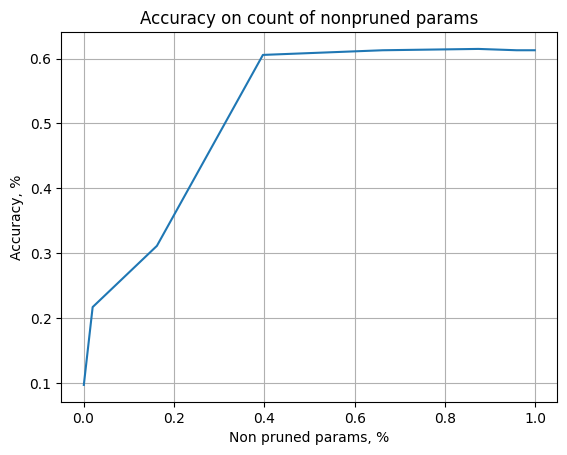

In [31]:
thresholds = np.linspace(-5, 5, 10)
threshold_results = trainer.eval_thresholds(model, thresholds)

# plot dependence of accuracy on count on non pruned parameter
x_s = [(a.cnt_prune_parameters / a.cnt_params).cpu().numpy() for a in threshold_results]
x_s = 1. - np.array(x_s) # now we get partition of non pruned parameters
y_s = [a.custom_losses["val_accuracy"] for a in threshold_results]

plt.plot(x_s, y_s)
plt.xlabel("Non pruned params, %")
plt.ylabel("Accuracy, %")
plt.title("Accuracy on count of nonpruned params")
plt.grid()